<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/movie_rec_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Word Embeddings Creation

# Word Embeddings Creation

import gensim

# Train the Word2Vec model
model = gensim.models.Word2Vec(tokenized_reviews, size=300, window=5, min_count=1, workers=8)
# Access the word vectors
word_vectors = model.wv


In [ ]:
Representing a place review into vector

import numpy as np

place_review_array = []
for review in place_reviews['Reviews']:
  word_vector = np.zeros((1, 300))
  for word in word_tokenize(review):
    word_vector += word_vectors[word]
  place_review_array.append(word_vector/len(review))

In [ ]:

place_review_array = np.array(place_review_array)
place_review_array = place_review_array.reshape(-1,300)
place_review_array.shape

In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 34.3 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

np.random.seed(123)

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()


In [ ]:
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "timestamp"],
)

<ipython-input-3-405a444cbfe5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(


In [ ]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In order to keep memory usage manageable within Kaggle's kernel, we will only use data from 30% of the users in this dataset. Let's randomly select 30% of the users and only use data from the selected users.

In [ ]:
rand_userIds = np.random.choice(ratings['user_id'].unique(),
                               size=int(len(ratings['user_id'].unique())*0.3),
                               replace=False)

ratings = ratings.loc[ratings['user_id'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings),len(rand_userIds)))

There are 300162 rows of data from 1812 users


In [ ]:
ratings.shape

(300162, 4)

In [ ]:
ratings.sample(10)

,user_id,movie_id,rating,timestamp
817968,4912,3051,4,962677313
594694,3620,1475,2,972867332
649147,3911,2302,5,965754196
527577,3261,303,4,968936704
453493,2793,2410,4,972937669
353512,2071,1597,4,974945824
309708,1842,2701,2,996465357
259881,1589,3555,3,974736461
916732,5539,1927,4,1043286180
729219,4360,762,2,965190011


Train-test split


Along with the rating, there is also a timestamp column that shows the date and time the review was submitted. Using the timestamp column, we will implement our train-test split strategy using the leave-one-out methodology. For each user, the most recent review is used as the test set (i.e. leave one out), while the rest will be used as training data .

To illustrate this, the movies reviewed by user 39,849 is shown below. The last movie reviewed by the user is the 2014 hit movie Guardians of The Galaxy. We'll use this movie as the testing data for this user, and use the rest of the reviewed movies as training data.


The train-test split strategy is often used when training and evaluating recommender systems. Doing a random split would not be fair, as we could potentially be using a user's recent reviews for training and earlier reiviews for testing. This introduces data leakage with a look-ahead bias, and the performance of the trained model would not be generalizable to real-world performance.

The code below will split our rating dataset into a train and test set using the leave-one-out methodology.

In [ ]:
ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'] \
                                .rank(method = 'first',ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no Longer need
train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]
test_ratings = test_ratings[['user_id','movie_id','rating']]

Converting the dataset into an implicit feedback dataset
As discussed earlier, we will train a recommender system using implicit feedback. However, the MovieLens dataset that we're using is based on explicit feedback. To convert this dataset into an implicit feedback dataset, we'll simply binarize the ratings such that they are are '1' (i.e. positive class). The value of '1' represents that the user has interacted with the item.

It is important to note that using implicit feedback reframes the problem that our recommender is trying to solve. Instead of trying to predict movie ratings (when using explicit feedback), we are trying to predict whether the user will interact (i.e. click/buy/watch) with each movie, with the aim of presenting to users the movies with the highest interaction likelihood.

In [ ]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,user_id,movie_id,rating
873081,5271,1230,1
727426,4352,2431,1
727268,4351,3566,1
150292,968,1912,1
36809,245,3918,1


We do have a problem now though. After binarizing our dataset, we see that every sample in the dataset now belongs to the positive class. However we also require negative samples to train our models, to indicate movies that the user has not interacted with. We assume that such movies are those that the user are not interested in - even though this is a sweeping assumption that may not be true, it usually works out rather well in practice.

The code below generates 4 negative samples for each row of data. In other words, the ratio of negative to positive samples is 4:1. This ratio is chosen arbitrarily but I found that it works rather well (feel free to find the best ratio yourself!)

In [ ]:
# Get a list of all movie IDs
all_movieIds = ratings['movie_id'].unique()

# Placeholfers that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each usesr has interaction with
user_item_set = set(zip(train_ratings['user_id'],train_ratings['movie_id']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/298350 [00:00<?, ?it/s]

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens Pytorch Dataset for Training
    Args:
        ratings(pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    """
    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__ (self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['user_id'], ratings['movie_id']))
        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(u)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

User Embeddings


Before we dive into the architecture of the model, let's familiarize ourselves with the concept of embeddings. An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space. To better understand this concept, let's take a closer look at user embeddings.

Imagine that we want to represent our users according to their preference for two genres of movies - action and romance movies. Let the first dimension be how much the user likes action movies, and the second dimension be how much the user likes romance movies.

earned Embeddings


Similarly, we will use a separate item embedding layer to represent the traits of the items (i.e. movies) in a lower dimensional space.

You might be wondering, how can we learn the weights of the embedding layer, such that it provides an accurate representation of users and items? In our previous example, we used Bob and Joe's preference for action and romance movies to manually create our embedding. Is there a way to learn such preferences automatically?

The answer is Collaborative Filtering - by using the ratings dataset, we can identify similar users and movies, creating user and item embeddings learned from existing ratings.

Model Architecture

Now that we have a better understanding of embeddings, we are ready to define the model architecture. As you'll see, the user and item embeddings are key to the model.

Let's walk through the model architecture using the following training sample:

The inputs to the model are the one-hot encoded user and item vector for userId = 3 and movieId = 1. Because this is a positive sample (movie actually rated by the user), the true label (interacted) is 1.

The user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors.

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output. Finally, we apply a Sigmoid function to obtain the most probable class. In the example above, the most probable class is 1 (positive class), since 0.8 > 0.2.

Now, let's define this NCF model using PyTorch Lightning!

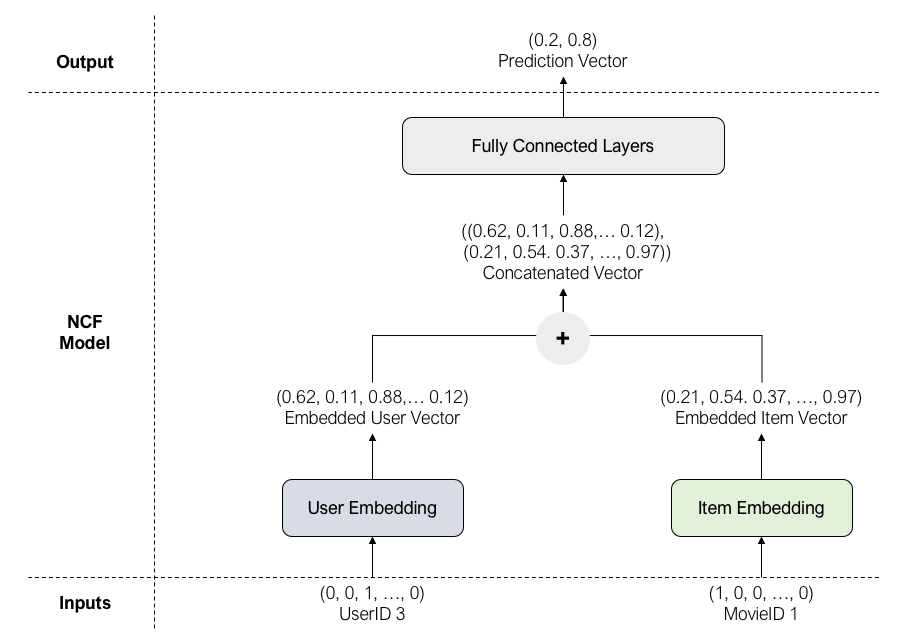

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['user_id'].max()+1
num_items = ratings['movie_id'].max()+1

all_movieIds = ratings['movie_id'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)


NCF model for 5 epochs using the GPU. Notice that we are using the argument reload_dataloaders_every_epoch=True. This creates a new randomly chosen set of negative samples for each epoch, which ensures that our model is not biased by the selection of negative samples.

Note: One advantage of PyTorch Lightning over vanilla PyTorch is that you don't need to write your own boiler plate training code. Notice how the Trainer class allows us to train our model with just a few lines of code.

In [ ]:
trainer = pl.Trainer(max_epochs=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 48.3 K
1 | item_embedding | Embedding | 31.6 K
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
83.2 K    Trainable params
0         Non-trainable params
83.2 K    Total params
0.333     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number 

Training: |          | 0/? [00:00<?, ?it/s]

IndexError: ignored

The key here is that we don't need the user to interact on every single item in the list of recommendations. Instead, we just need the user to interact with at least one item on the list - as long as the user does that, the recommendations have worked.

To simulate this, let's run the following evaluation protocol to generate a list of 10 recommended items for each user.

For each user, randomly select 99 items that the user has not interacted with Combine these 99 items with the test item (the actual item that the user interacted with). We now have 100 items. Run the model on these 100 items, and rank them according to their predicted probabilities Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit. Repeat the process for all users. The Hit Ratio is then the average hits. This evaluation protocol is known as Hit Ratio @ 10, and it is commonly used to evaluate recommender systems.

In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['user_id'], test_ratings['movie_id']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('user_id')['movie_id'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    print("Items:",top10_items)
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/1812 [00:00<?, ?it/s]

[2860, 274, 802, 718, 3185, 1426, 2046, 1466, 69, 666, 3758, 2164, 2096, 2777, 506, 3508, 1928, 3727, 3552, 1930, 1425, 568, 514, 2210, 3005, 3821, 1063, 1704, 1142, 3885, 3298, 496, 602, 55, 1417, 2993, 3493, 870, 217, 2048, 57, 2979, 2144, 3895, 618, 149, 2074, 2297, 2146, 2047, 1383, 1334, 2823, 562, 2246, 2338, 31, 3680, 3822, 1306, 3852, 1511, 3807, 3823, 3498, 1084, 3139, 1814, 3289, 1602, 1226, 2150, 779, 3196, 1899, 3909, 3638, 3405, 2779, 1102, 3364, 1222, 3723, 3518, 3421, 1862, 3548, 573, 2962, 3778, 2099, 3577, 3155, 1909, 1519, 454, 3182, 3857, 1680]
Items: [1142, 718, 3160, 3807, 666, 1306, 1425, 1511, 506, 496]
[3845, 14, 3358, 1306, 3622, 3928, 3466, 181, 609, 567, 2661, 2031, 249, 3144, 3919, 3548, 2178, 3122, 1055, 1668, 955, 1053, 1885, 3743, 917, 1484, 1668, 617, 1520, 2246, 1268, 541, 3487, 3894, 1597, 1984, 1976, 1950, 1563, 3184, 1869, 1334, 2609, 1274, 1104, 906, 3471, 791, 216, 385, 1076, 2275, 1567, 1550, 3395, 1006, 2934, 741, 1055, 3020, 431, 50, 3896, 680, 